Subpocket occupancy:
- Number of fragments and unique fragments per subpocket
- Number of subpockets occupied by each ligand 

Fragment occurrences:
- Most common fragments per subpocket

In [1]:
import glob
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path_to_library = '/home/paula/Masterarbeit/FragmentLibrary/'

# list of folders for each subpocket
subpockets = ['AP', 'FP', 'SE', 'GA', 'B1', 'B2', 'X']
folders = [path_to_library+subpocket for subpocket in subpockets]

In [3]:
# read data

data = pd.DataFrame()

# iterate over subpockets
for i, folder in enumerate(folders):
    
    subpocket = subpockets[i]
    
    file = folder+'/'+subpocket+'.sdf' 
    df = pd.DataFrame()
    suppl = Chem.SDMolSupplier(file, removeHs=False)
        
    fragments = []
    fingerprints = []
    smiles = []
    groups = []

    for frag in suppl:
        # remove dummy atoms from fragments and create smiles
        du = Chem.MolFromSmiles('*')
        h = Chem.MolFromSmiles('[H]', sanitize=False)
        fixed_frag = AllChem.ReplaceSubstructs(frag, du, h, replaceAll=True)[0]
        fixed_frag = Chem.RemoveHs(fixed_frag)
        # create smiles BEFORE 2D computation because unnecessary stereochemistry will be added!
        # smiles for comparing fragments
        s = Chem.MolToSmiles(fixed_frag)
        smiles.append(s)
        # 2D coordinates
        tmp = AllChem.Compute2DCoords(fixed_frag)
        fragments.append(fixed_frag)
        # kinase group
        groups.append(frag.GetProp('group'))
     
    df['smiles'] = smiles
    df['fragment'] = fragments
    df['subpocket'] = subpocket
    df['group'] = groups
    
    data = data.append(df)
    
data = data.reset_index(drop=True)
data.shape

(7486, 4)

In [4]:
df_AP = data[data.subpocket=='AP']
df_FP = data[data.subpocket=='FP']
df_SE = data[data.subpocket=='SE']
df_GA = data[data.subpocket=='GA']
df_B1 = data[data.subpocket=='B1']
df_B2 = data[data.subpocket=='B2']

## Subpocket occupancy:

In [5]:
n_frags_per_sp = []
n_unique = []
for sp in subpockets:
    df = data[data.subpocket==sp]
    n_frags_per_sp.append(df.shape[0])
    df_unique = df.drop_duplicates(subset='smiles')
    n_unique.append(df_unique.shape[0])

In [6]:
colors=['purple','forestgreen','c','tab:orange','tab:blue','darkslateblue', 'grey']

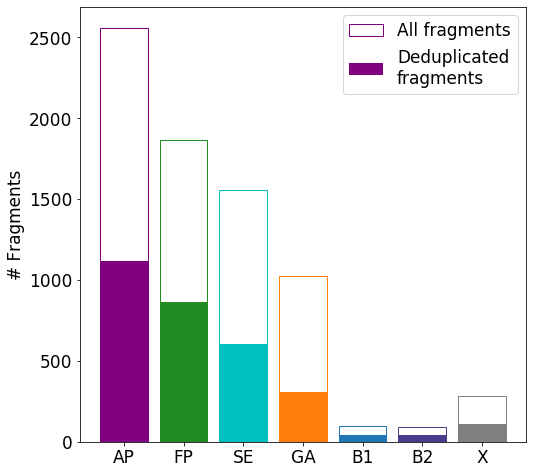

In [11]:
plt.figure(figsize=(8,8))
plt.bar(subpockets, n_frags_per_sp, fill=False, edgecolor=colors)
plt.bar(subpockets, n_unique, color=colors)
plt.legend(['All fragments', 'Deduplicated\nfragments'], fontsize=17)
plt.ylabel('# Fragments', fontsize=17)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
sum(n_frags_per_sp), n_frags_per_sp, sum(n_unique), n_unique
plt.savefig('/home/paula/Masterarbeit/manuscript/Figures/fa_subpocket_occ.pdf', dpi=300)

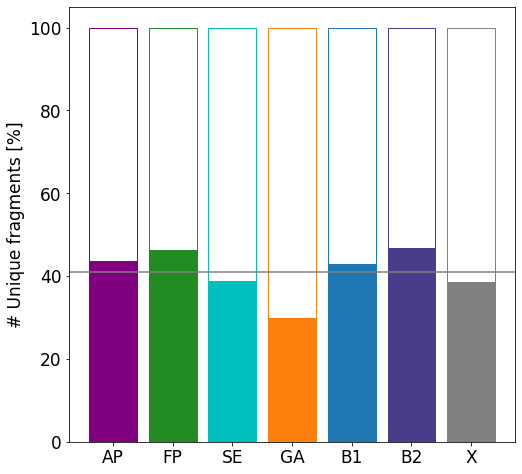

(array([43.53768059, 46.3022508 , 38.91025641, 29.8828125 , 42.85714286,
        46.73913043, 38.59649123]), 40.97510926108982)

In [8]:
p_unique = np.asarray(n_unique)/np.asarray(n_frags_per_sp)*100
p_unique_average = sum(p_unique)/len(subpockets)
plt.figure(figsize=(8,8))
plt.bar(subpockets, [100 for x in subpockets], fill=False, edgecolor=colors)
plt.bar(subpockets, p_unique, color=colors)
plt.axhline(p_unique_average, color='grey')
plt.ylabel('# Unique fragments [%]', fontsize=17)
plt.yticks(range(0,101,20), fontsize=17)
plt.xticks(fontsize=17)
plt.show()
p_unique, p_unique_average

- Number of subpockets occupied by the ligands:

In [9]:
n_sp = {1: 127, 2: 719, 3: 1350, 4: 327, 5: 29, 6: 1}
n_sp.values()

dict_values([127, 719, 1350, 327, 29, 1])

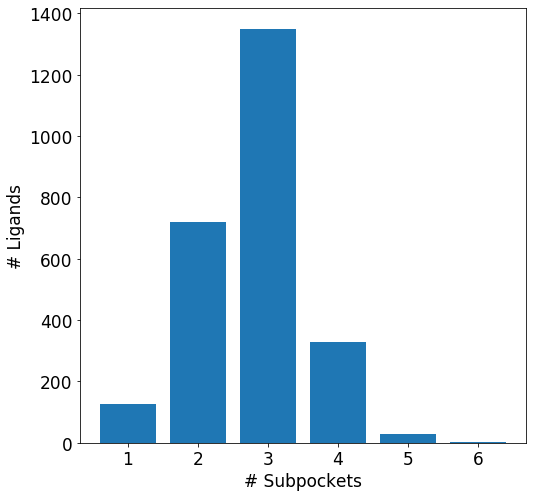

In [12]:
plt.figure(figsize=(8,8))
plt.bar(n_sp.keys(), n_sp.values())
plt.ylabel('# Ligands', fontsize=17)
plt.xlabel('# Subpockets', fontsize=17)
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)
plt.savefig('/home/paula/Masterarbeit/manuscript/Figures/fa_n_subpockets.pdf', dpi=300)

## Fragment occurrences:

For each subpocket, show:
* Number of fragments
* Number of unique fragments
* Fragments with highest number of occurences

### Adenine Pocket

In [12]:
n_frags = df_AP.shape[0]
print('Number of fragments: ', n_frags)

# number of unique fragments
frags_unique = df_AP.drop_duplicates(subset='smiles')
n_unique = frags_unique.shape[0]
print('Number of unique fragments: ', n_unique)

Number of fragments:  2561
Number of unique fragments:  1115


AP fragments with highest number of occurences:


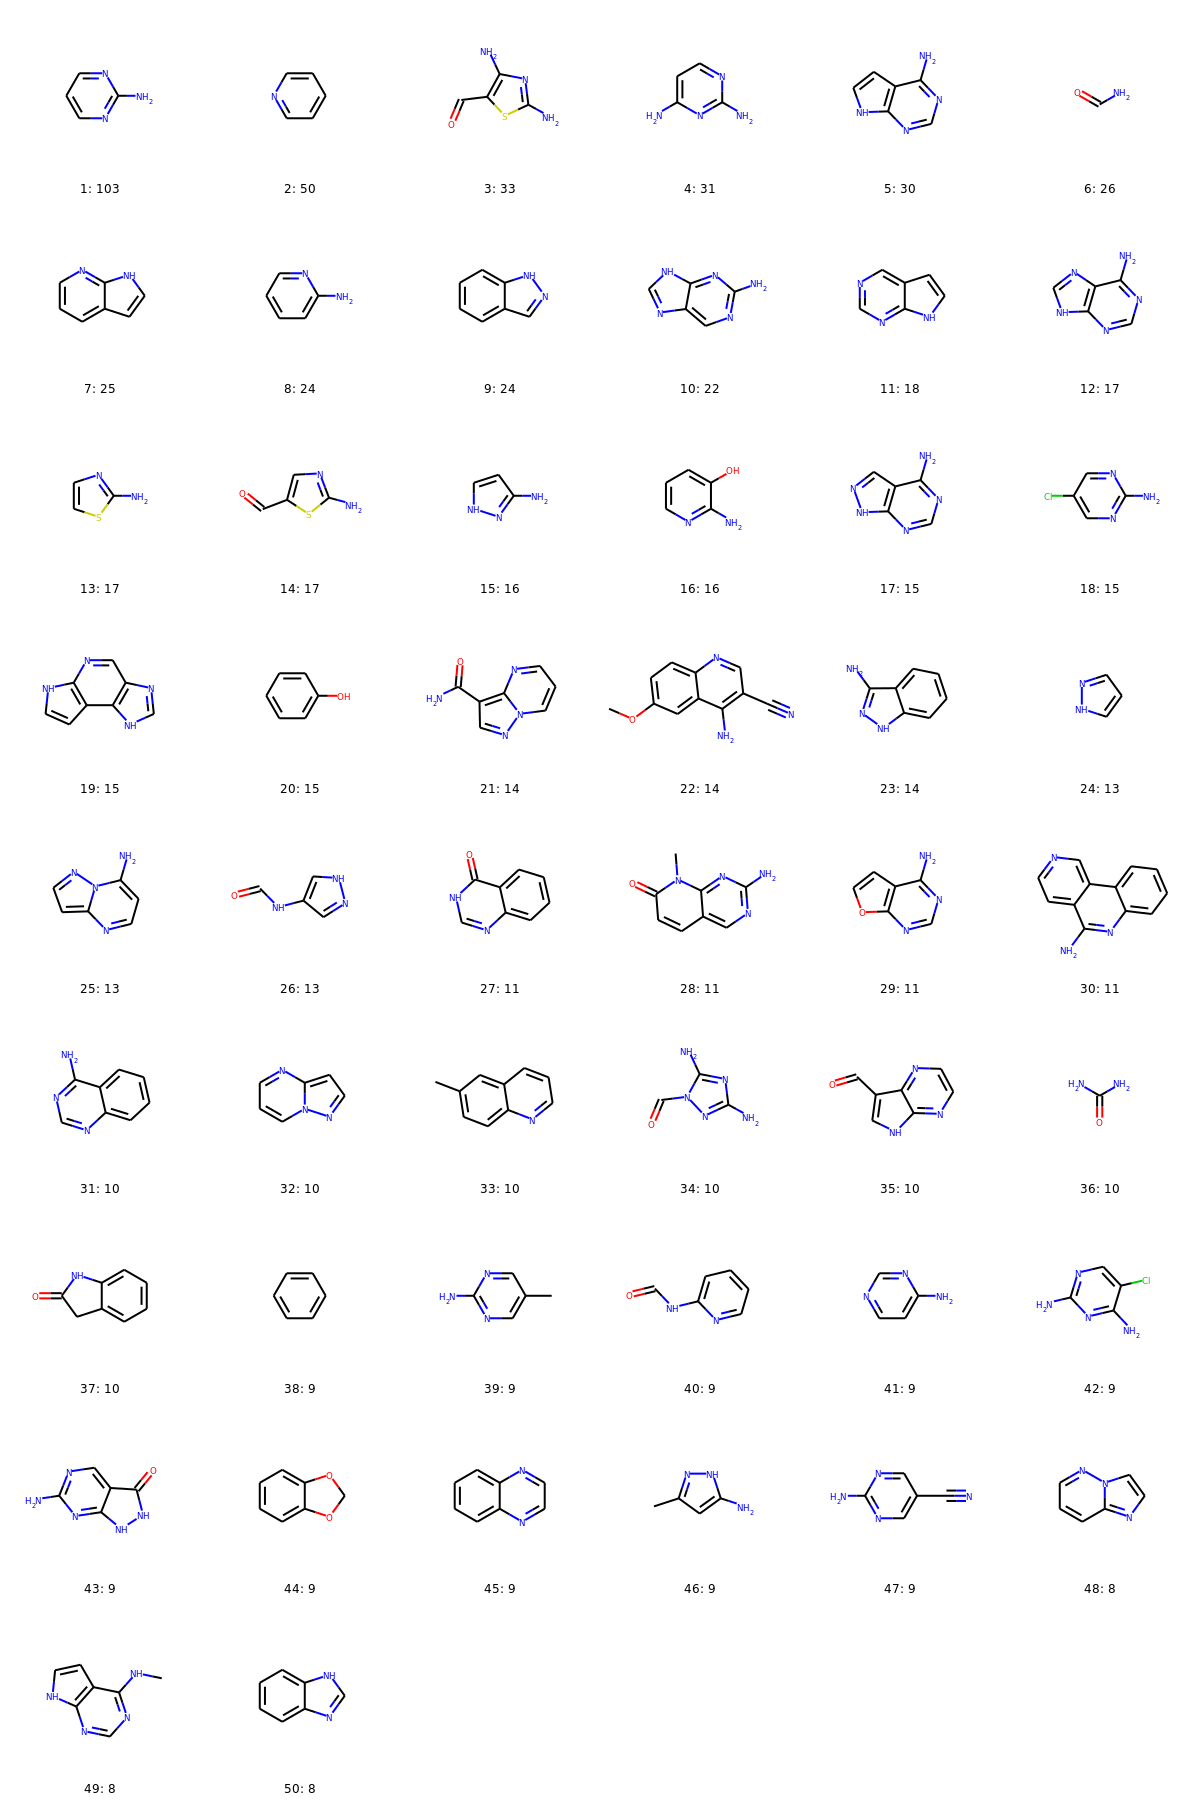

In [11]:
print('AP fragments with highest number of occurences:')

frag_counts = df_AP.smiles.value_counts()
frags_max = [Chem.MolFromSmiles(smiles) for smiles in frag_counts.index]
Draw.MolsToGridImage(frags_max[:50], legends=[str(i+1)+': '+str(x) for i, x in enumerate(frag_counts)], molsPerRow=6)

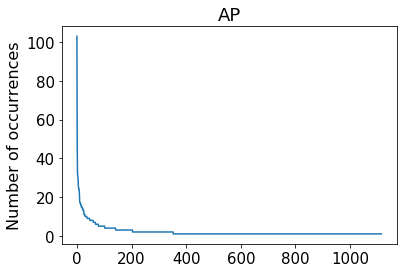

In [16]:
plt.plot(list(frag_counts))
# plt.xlabel('Fragment', fontsize=15)
plt.ylabel('Number of occurrences', fontsize=16)
plt.title('AP', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(path_to_library+'/AP/NumOccur.png')
plt.show()

Number of unique fragments per kinase group:

In [17]:
n_frags_per_group = df_AP.groupby('group').count()['smiles']
n_unique_per_group = df_AP.groupby('group').smiles.nunique()
pd.DataFrame({'Number of fragments': n_frags_per_group, 'Number of unique fragments': n_unique_per_group})

,Number of fragments,Number of unique fragments
group,,
AGC,137,70
CAMK,368,264
CK1,49,35
CMGC,820,411
Other,247,140
STE,113,74
TK,666,308
TKL,161,97


### Front pocket

In [8]:
n_frags = df_FP.shape[0]
print('Number of fragments: ', n_frags)

# number of unique fragments
frags_unique = df_FP.drop_duplicates(subset='smiles')
n_unique = frags_unique.shape[0]
print('Number of unique fragments: ', n_unique)

Number of fragments:  1866
Number of unique fragments:  864


FP fragments with highest number of occurences:


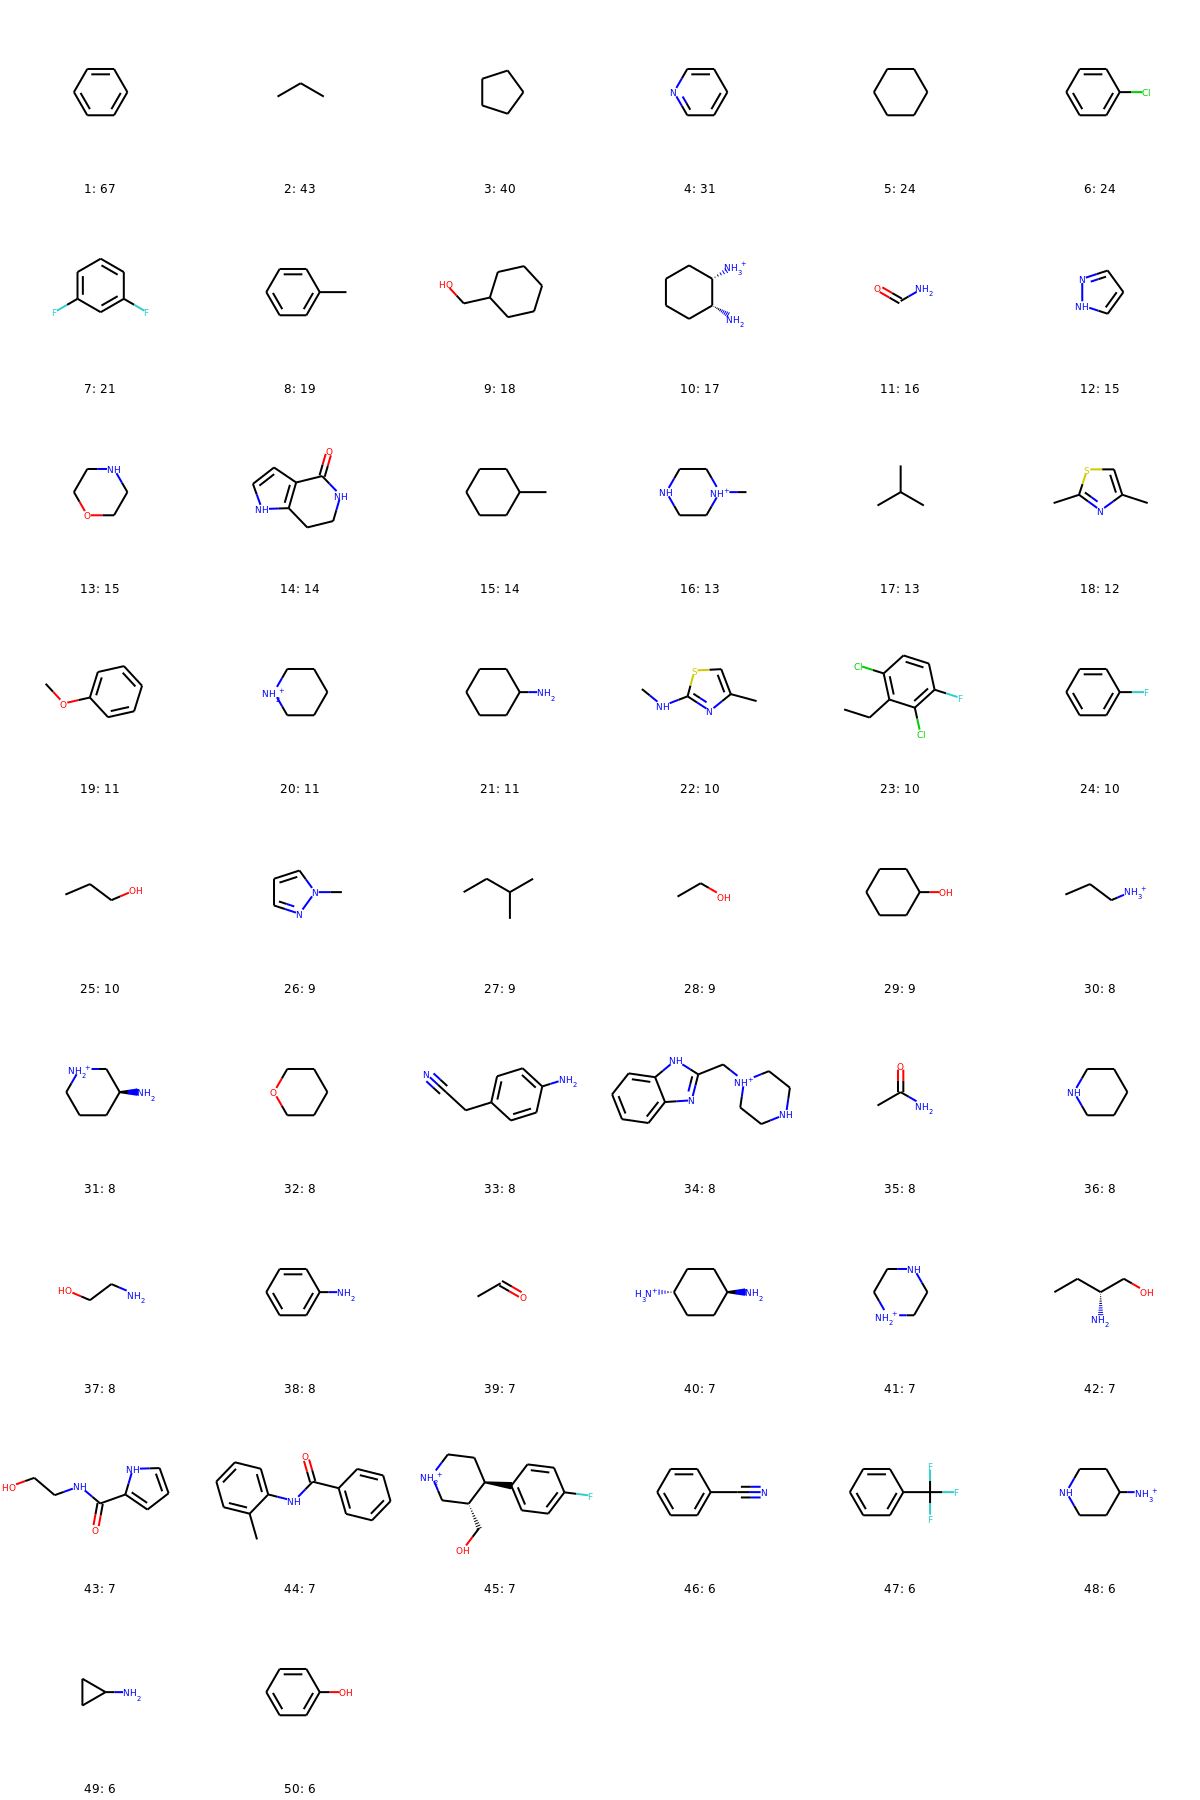

In [12]:
print('FP fragments with highest number of occurences:')

frag_counts = df_FP.smiles.value_counts()
frags_max = [Chem.MolFromSmiles(smiles) for smiles in frag_counts.index]
Draw.MolsToGridImage(frags_max[:50], legends=[str(i+1)+': '+str(x) for i, x in enumerate(frag_counts)], molsPerRow=6)

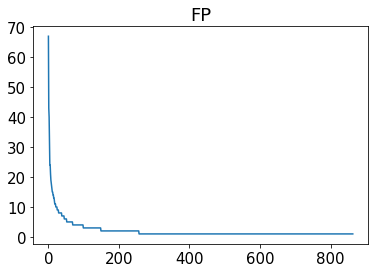

In [20]:
plt.plot(list(frag_counts))
plt.title('FP', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(path_to_library+'/FP/NumOccur.png')
plt.show()

Number of unique fragments per kinase group:

In [21]:
n_frags_per_group = df_FP.groupby('group').count()['smiles']
n_unique_per_group = df_FP.groupby('group').smiles.nunique()
pd.DataFrame({'Number of fragments': n_frags_per_group, 'Number of unique fragments': n_unique_per_group})

,Number of fragments,Number of unique fragments
group,,
AGC,128,102
CAMK,241,156
CK1,33,22
CMGC,550,286
Other,193,102
STE,69,48
TK,552,313
TKL,100,58


### SE pocket

In [13]:
n_frags = df_SE.shape[0]
print('Number of fragments: ', n_frags)

# number of unique fragments
frags_unique = df_SE.drop_duplicates(subset='smiles')
n_unique = frags_unique.shape[0]
print('Number of unique fragments: ', n_unique)

Number of fragments:  1560
Number of unique fragments:  607


SE fragments with highest number of occurences:


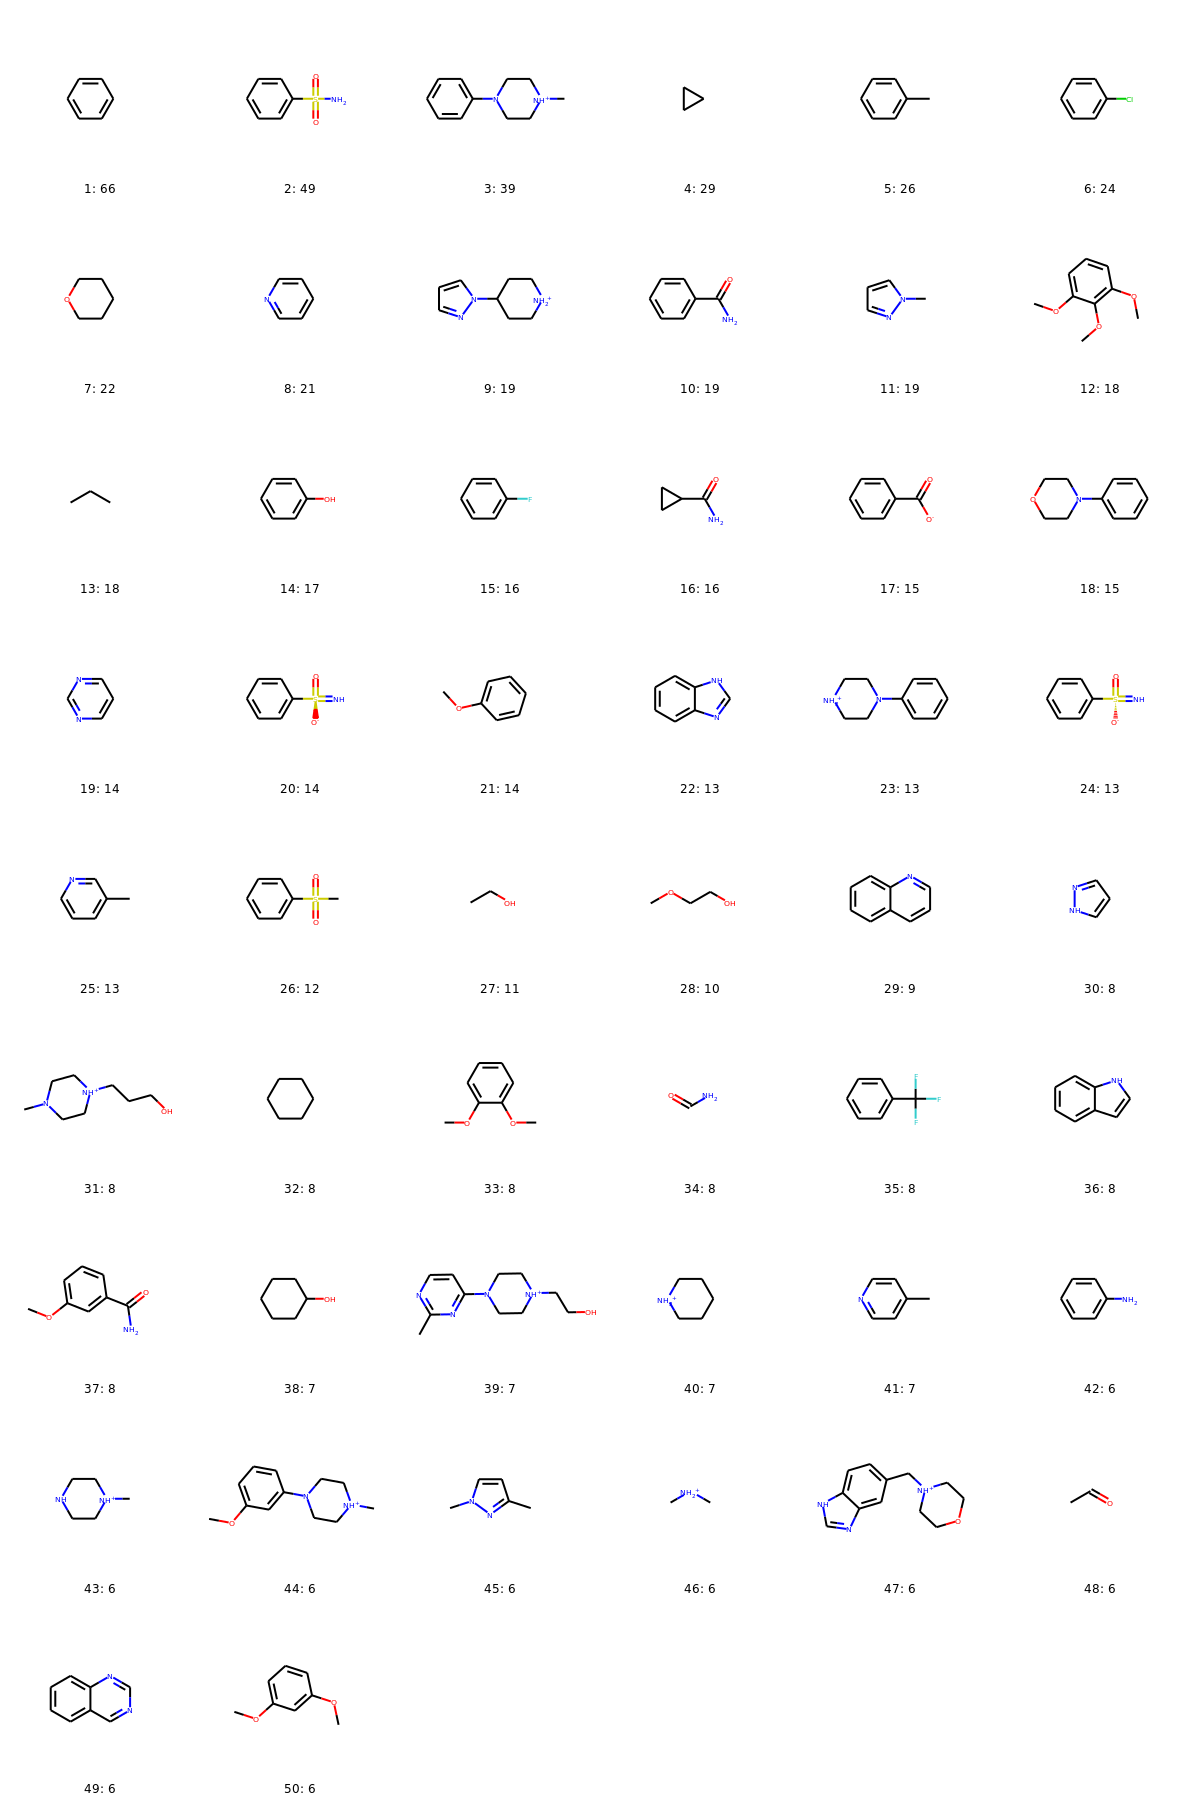

In [14]:
print('SE fragments with highest number of occurences:')

frag_counts = df_SE.smiles.value_counts()
frags_max = [Chem.MolFromSmiles(smiles) for smiles in frag_counts.index]
Draw.MolsToGridImage(frags_max[:50], legends=[str(i+1)+': '+str(x) for i, x in enumerate(frag_counts)], molsPerRow=6)

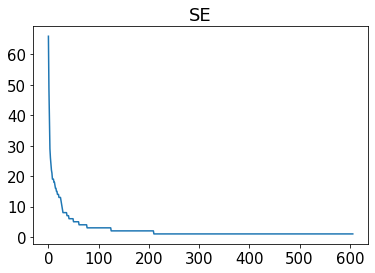

In [24]:
plt.plot(list(frag_counts))
plt.title('SE', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(path_to_library+'/SE/NumOccur.png')
plt.show()

### Gate area

In [15]:
n_frags = df_GA.shape[0]
print('Number of fragments: ', n_frags)

# number of unique fragments
frags_unique = df_GA.drop_duplicates(subset='smiles')
n_unique = frags_unique.shape[0]
print('Number of unique fragments: ', n_unique)

Number of fragments:  1024
Number of unique fragments:  306


GA fragments with highest number of occurences:


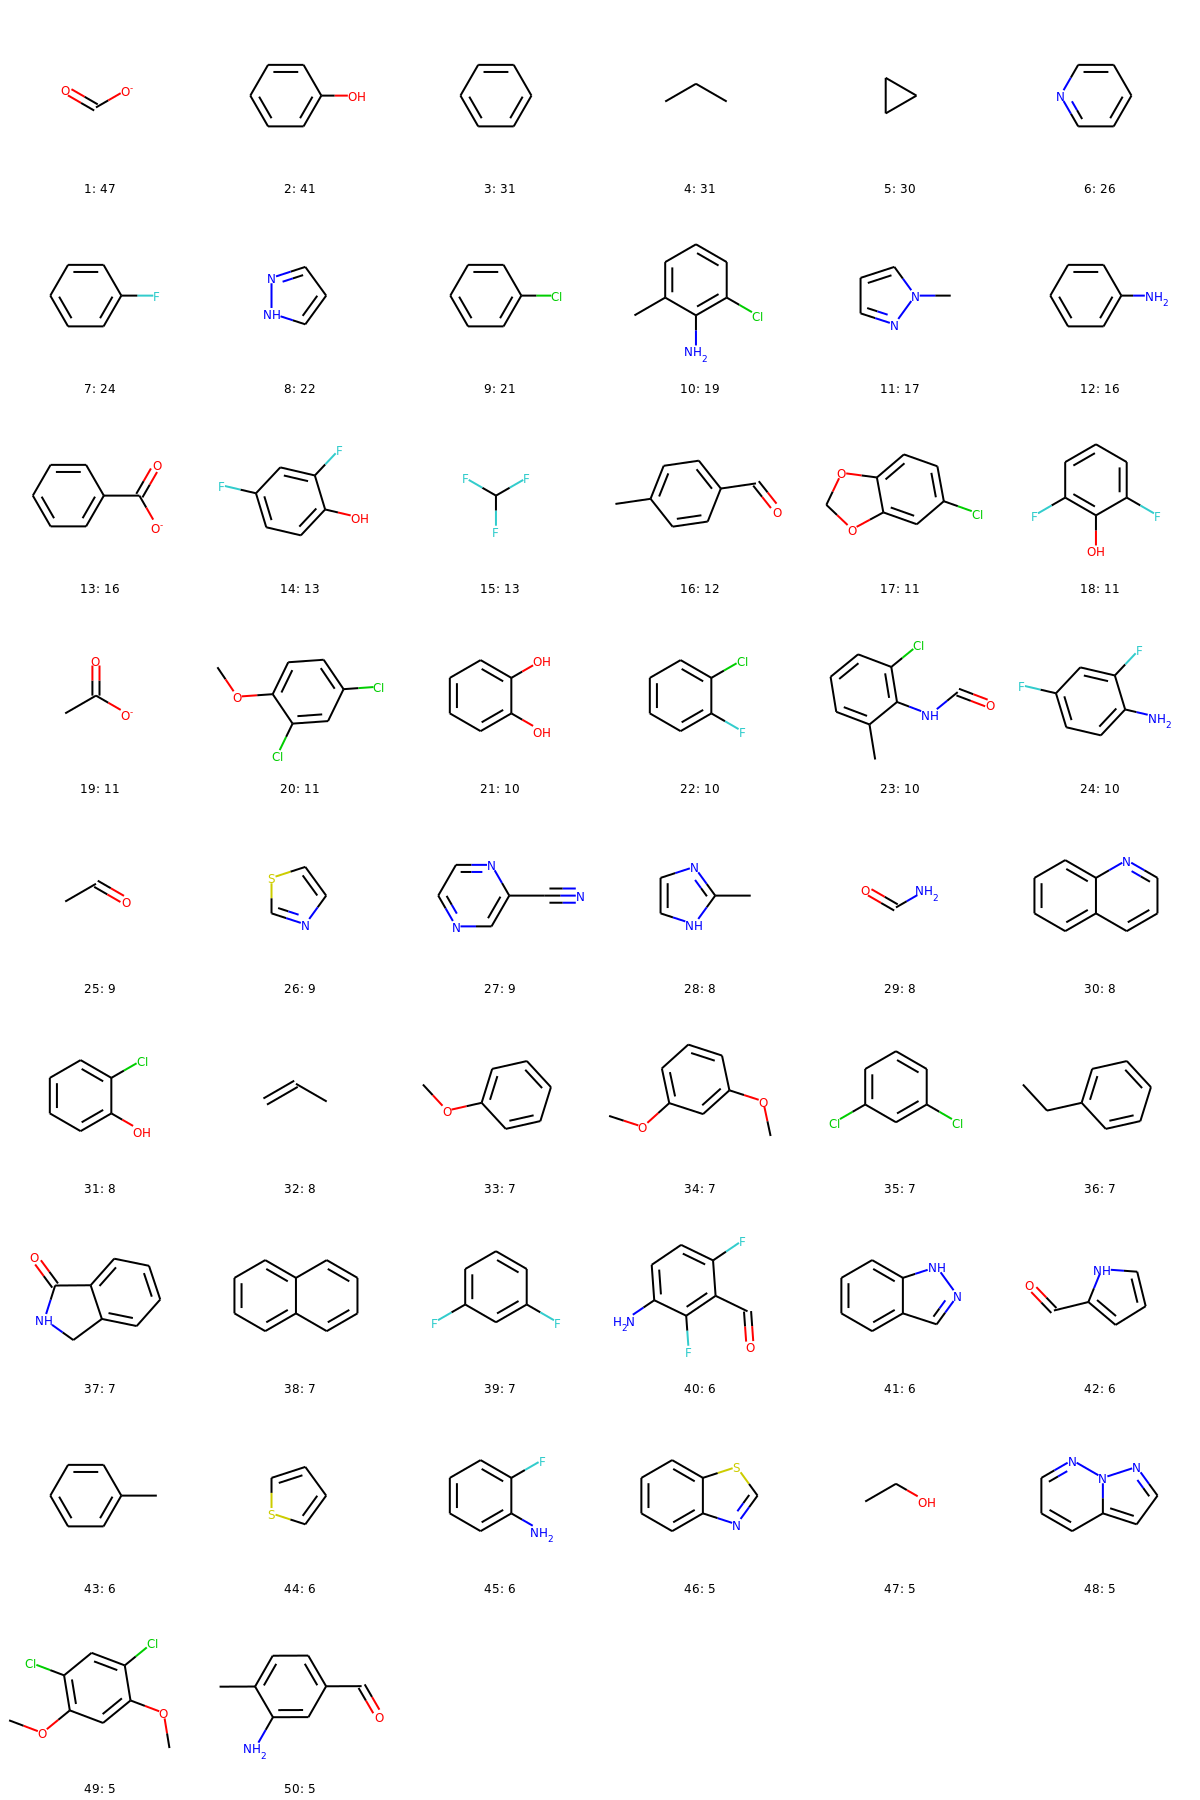

In [16]:
print('GA fragments with highest number of occurences:')

frag_counts = df_GA.smiles.value_counts()
frags_max = [Chem.MolFromSmiles(smiles) for smiles in frag_counts.index]
Draw.MolsToGridImage(frags_max[:50], legends=[str(i+1)+': '+str(x) for i, x in enumerate(frag_counts)], molsPerRow=6)

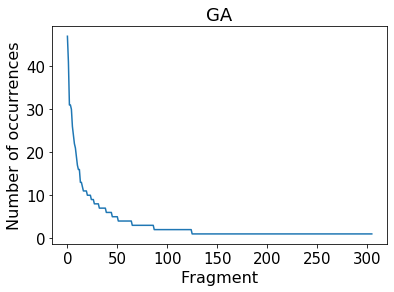

In [27]:
plt.plot(list(frag_counts))
plt.xlabel('Fragment', fontsize=16)
plt.ylabel('Number of occurrences', fontsize=16)
plt.title('GA', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(path_to_library+'/GA/NumOccur.png')
plt.show()

### Back pocket I

In [17]:
n_frags = df_B1.shape[0]
print('Number of fragments: ', n_frags)

# number of unique fragments
frags_unique = df_B1.drop_duplicates(subset='smiles')
n_unique = frags_unique.shape[0]
print('Number of unique fragments: ', n_unique)

Number of fragments:  98
Number of unique fragments:  42


B1 fragments with highest number of occurences:


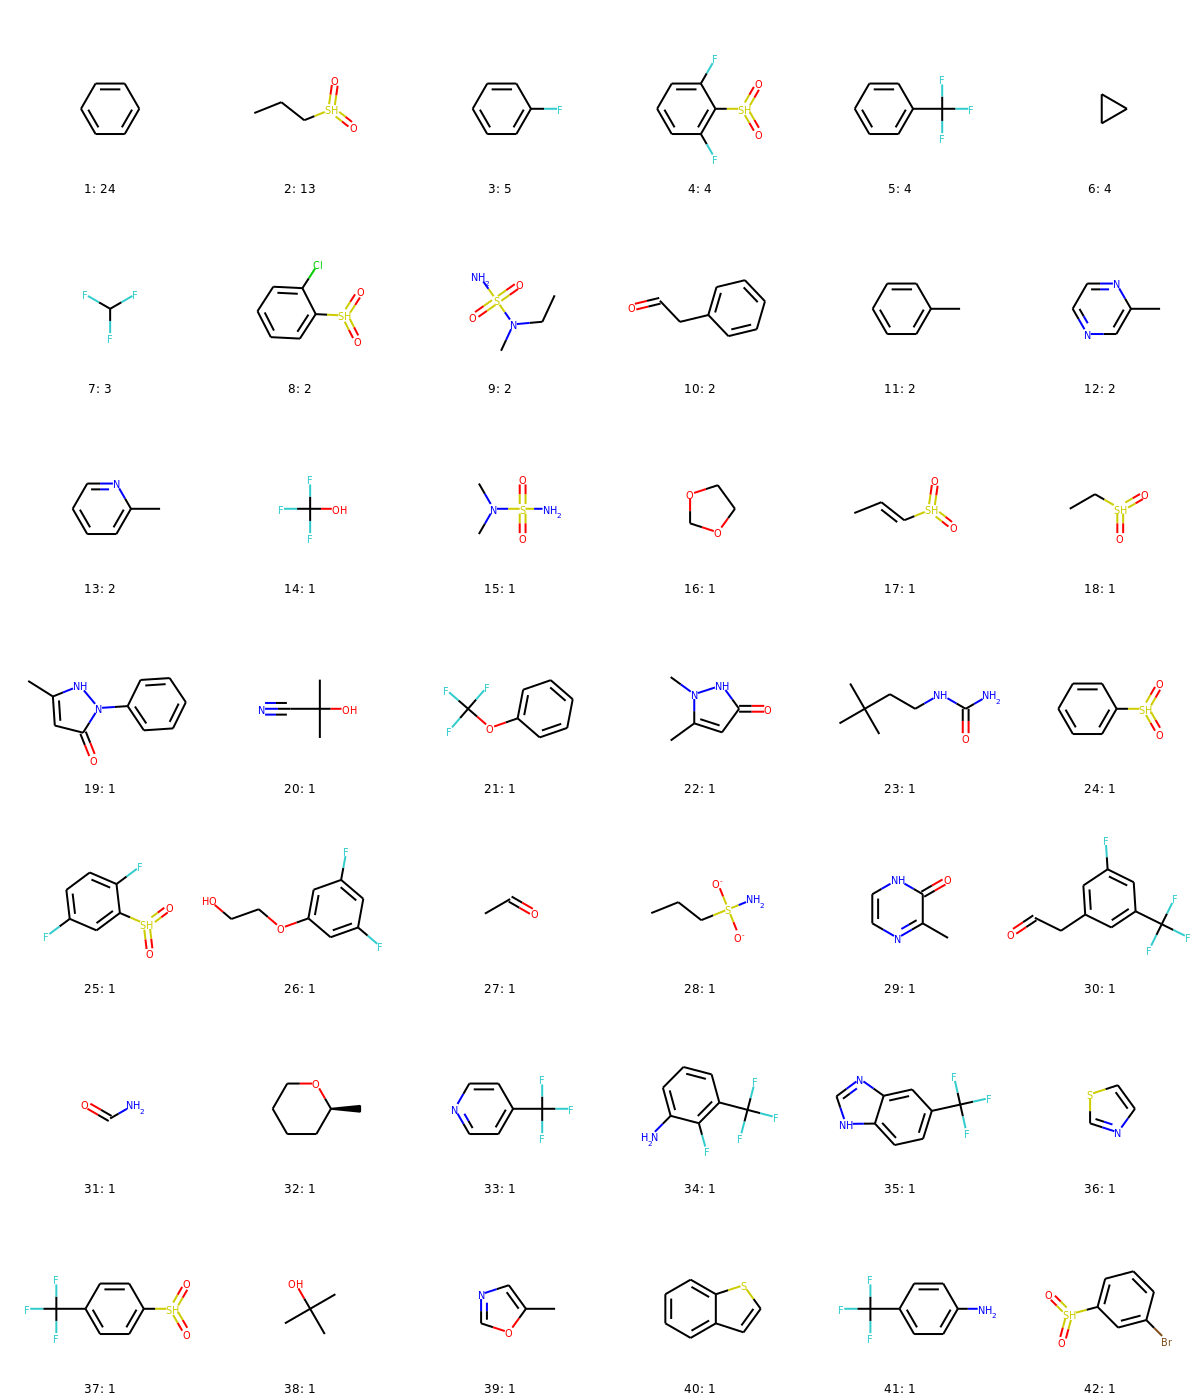

In [18]:
print('B1 fragments with highest number of occurences:')

frag_counts = df_B1.smiles.value_counts()
frags_max = [Chem.MolFromSmiles(smiles) for smiles in frag_counts.index]
Draw.MolsToGridImage(frags_max[:50], legends=[str(i+1)+': '+str(x) for i, x in enumerate(frag_counts)], molsPerRow=6)

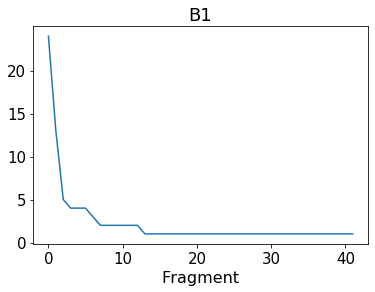

In [30]:
plt.plot(list(frag_counts))
plt.xlabel('Fragment', fontsize=16)
plt.title('B1', fontsize=18)
plt.yticks(range(0,21,5), fontsize=15)
plt.xticks(fontsize=15)
plt.savefig(path_to_library+'/B1/NumOccur.png')
plt.show()

### Back pocket II

In [19]:
n_frags = df_B2.shape[0]
print('Number of fragments: ', n_frags)

# number of unique fragments
frags_unique = df_B2.drop_duplicates(subset='smiles')
n_unique = frags_unique.shape[0]
print('Number of unique fragments: ', n_unique)

Number of fragments:  92
Number of unique fragments:  43


FP fragments with highest number of occurences:


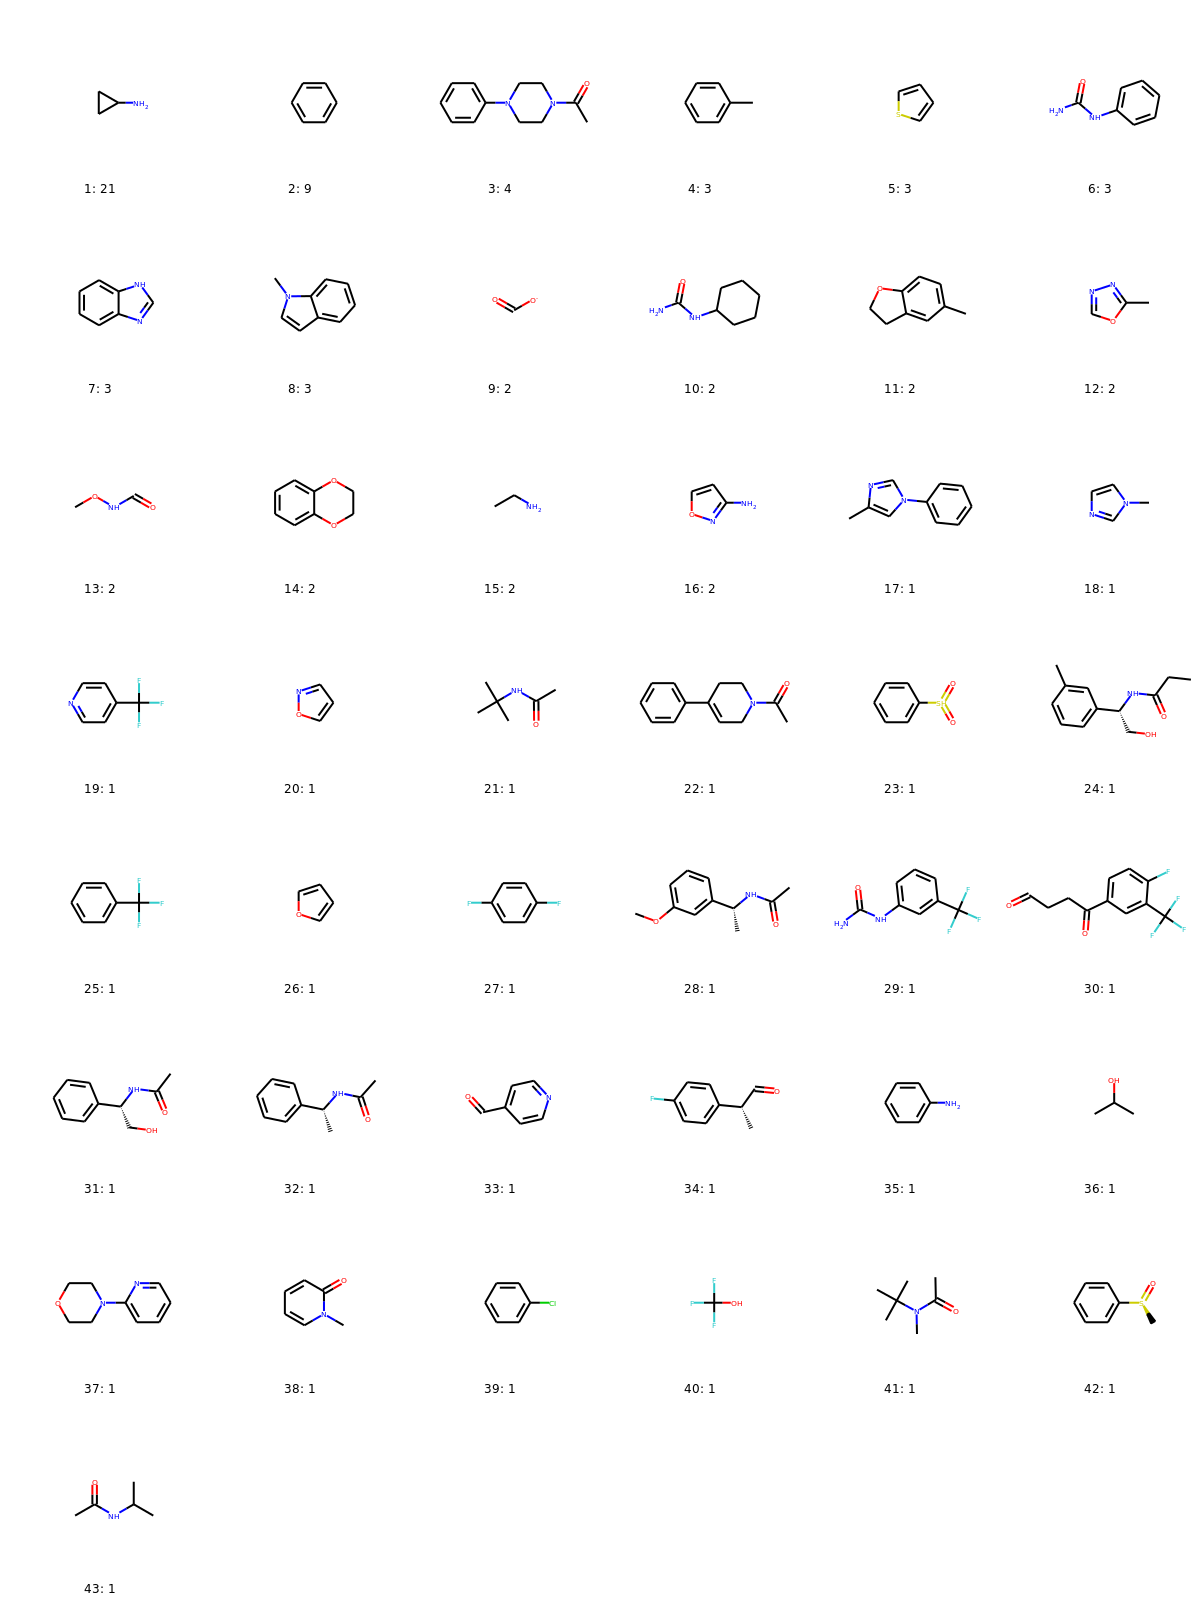

In [23]:
print('FP fragments with highest number of occurences:')

frag_counts = df_B2.smiles.value_counts()
frags_max = [Chem.MolFromSmiles(smiles) for smiles in frag_counts.index]
Draw.MolsToGridImage(frags_max[:50], legends=[str(i+1)+': '+str(x) for i, x in enumerate(frag_counts)], molsPerRow=6)

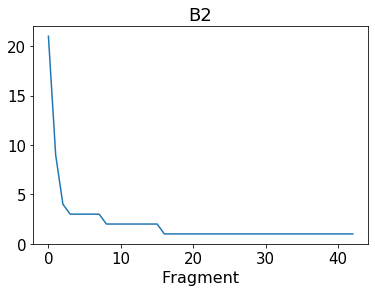

In [33]:
plt.plot(list(frag_counts))
plt.xlabel('Fragment', fontsize=16)
plt.title('B2', fontsize=18)
plt.yticks(range(0,21,5), fontsize=15)
plt.xticks(fontsize=15)
plt.savefig(path_to_library+'/B2/NumOccur.png')
plt.show()